# Python Perfomance Options

Python is a programming language that is chosen often for the easy and forgiving syntax.
Unfortunately, as we will see, the same features that make Python this easy are also the features that make it very slow compared to many other languages.

We will discuss a few options on how to speed up calculations.

Before we begin, I want to point out what we will not be discussing here. 
We will not be discussing File I/O -- i.e. how to make the program read or write data from/to disk faster. 
There are very few things you can do once the hardware is in place to speed up that process, and for the few cases where there might be a difference to be made, other tutorials will talk about that.

We will also not be discussing parallelisation and dask, which can be used to speed up the computation, but is discussed widely elsewhere.
This post will be discussing on how to overcome the inherent performance issues with Python itself.

## Example Challenge: Interpolation

To compare different methods, we will have different methods to perform the same task: A linear interpolation of a large array.

That is, we will have three arrays:

- `X0` - The x-components of the initial dataset
- `Y0` - The corresponding y-component, so it must have the same length as `X0`.
- `X1` - The new x-components that we want to interpolate to.

And we want to get the y-components `Y1`, that correspond to the values of `X1` and follow the same procedure.

A linear interpolation means that the value of `y` for a new point `x` depends only on the two `y` components of the original dataset 
just to the left and just to the right of the new `x` value, like this:

$$y = \frac {y_0(x_1-x) + y_1(x-x_0)}{(x_1-x_0)}$$

where $y$ is the new y-component in the new grid, $x$ is the x-component of the new grid, $x_0$ amd $y_0$ are the coordinates in the old grid just smaller than $x$, and $x_1$ and $y_1$ are the coordinates in the old grid just larger than $x$.

<div style="max-width:250px">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/LinearInterpolation.svg/1920px-LinearInterpolation.svg.png" />
</div>

### Verification
We will verify that we get the same values by calling the numpy function `allclose()` on the arrays to check whether they're all the same.
Note that it's usually not a good idea to compare floating point variables for absolute identity, as changing the order of operations might cause different rounding errors that lead to every so small differences in the actual values.

We will use the `assert` keyword, which does nothing at all if the allclose returns `True`, but will leave a big `AssertionError` if allclose returns `False`.

## Native Python

To get a baseline for the performance, we will start with doing it all in Python natively.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, pi
sns.set_theme()
timings = {}


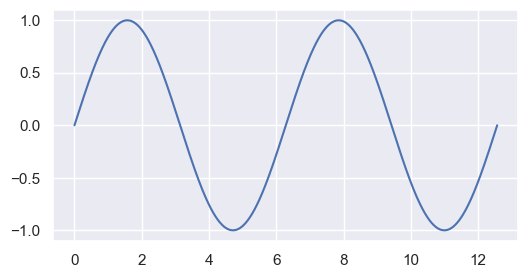

In [2]:
N0 = 100_000
X0 = [(4.0 * pi / N0) * i for i in range(N0)]
Y0 = [sin(x) for x in X0]
N1 = 40_000
X1 = [(3.0 * pi / N1) * i + 1e-4 for i in range(N1)]
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X0, Y0)
plt.show()

In [3]:
## Note that I'm using type hints hers.
## This is a feature of Python 3.5 and later.
## They will have no effect on the code's performance,
## but make the code more understandable.
def lin_interp(x_0: float, y_0: float, x_1: float, y_1: float, x: float) -> float:
    return (y_0 * (x_1 - x) + y_1 * (x - x_0)) / (x_1 - x_0)

def interp(X0, Y0, X1):
    idx0 = 0 
    Y1 = [0.0] * len(X1)
    for idx1, x1 in enumerate(X1):
        while X0[idx0] < x1:
            idx0 += 1
        if X0[idx0] == x1:
            Y1[idx1] = Y0[idx0]
        else:
            Y1[idx1] = lin_interp(X0[idx0 - 1], Y0[idx0 - 1], X0[idx0], Y0[idx0], X1[idx1])
    return Y1

timings['python'] = %timeit -o interp(X0, Y0, X1)

Y1_python = interp(X0, Y0, X1)

6.66 ms ± 73.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As you can see, on my computer this has taken about 7 ms on average.
This might not seem like much, but if we have a multi-dimensional array, this will take some time.

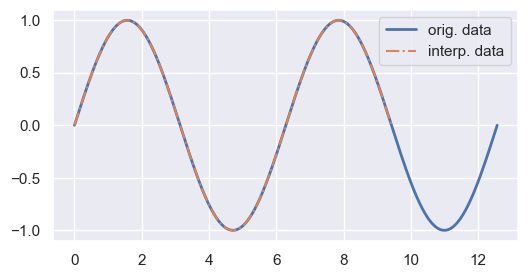

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X0, Y0, linewidth=2, label='orig. data')
ax.plot(X1, Y1_python, '-.', label='interp. data')
ax.legend()
plt.show()

## Using numpy

Lists aren't the most performant way to store arrays of constant type inside Python.
For those items, numpy was created.

Numpy is the backbone of most of the often-used computation routines, including `scipy`, `dask`, and `xarray`.

In [5]:
import numpy as np
X0 = np.array(X0)
Y0 = np.array(Y0)
X1 = np.array(X1)

As it happens, `numpy` has an interpolation routine already implemented.
Using it is pretty straightforward:

In [6]:
timings['numpy'] = %timeit -o np.interp(X1, X0, Y0)

Y1_numpy = np.interp(X1, X0, Y0)
assert np.allclose(Y1_python, Y1_numpy)

710 µs ± 317 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can see that the numpy calculation took a bit more than half a Millisecond, an order of magnitude times faster than our own list implementation.

If such an option is availalbe for your use case, this is where you should stop. 
Numpy is generally coded efficiently and you will spend a lot of time coding to get a little bit more performance out of it.

But for the reminder of the post, we will assume that our task is too unusual to find such an implementation, or we will be running it hundreds of thousands of times, and we will need to create our own.
We will still continue to use numpy as the array, though.

## Scipy
If `numpy` doesn't deliver the method we are seeking, we should have a closer look at `scipy`. 
This package comes with such a wide range of scientifically important methods that it's almost inconcevable that we wouldn't find what we need.

Specifically, the `scipy` package has an `interpolate` section that contains the method `interp1d`, which does what we want.

In [7]:
from scipy.interpolate import interp1d

interpolator = interp1d(X0, Y0, kind='linear')
timings['scipy'] = %timeit -o interpolator(X1)

Y1_scipy = interpolator(X1)
assert np.allclose(Y1_numpy, Y1_scipy)

752 µs ± 6.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



## Numba

Numba has been specifically to 'Just In Time' compile functions for added performance.
It is used by adding the Numba Just In Time `@jit` [decorator](https://realpython.com/primer-on-python-decorators/) before the function declaration.

This makes numba compile the code before execution, making it much, much faster.

You can read more about Numba [here](https://numba.pydata.org).

In [8]:
from numba import jit

@jit
def lin_interp_numba(x_0: float, y_0: float, x_1: float, y_1: float, x: float) -> float:
    return (y_0 * (x_1 - x) + y_1 * (x - x_0)) / (x_1 - x_0)

@jit
def interp_numba(X0, Y0, X1):
    Y1 = np.empty_like(X1)
    idx0 = 0
    for idx1, x1 in enumerate(X1):
        while X0[idx0] < x1:
            idx0 += 1
        if X0[idx0] == x1:
            Y1[idx1] = Y0[idx0]
        else:
            Y1[idx1] = lin_interp_numba(X0[idx0 - 1], Y0[idx0 - 1], X0[idx0], Y0[idx0], X1[idx1])
    return Y1

In [9]:
timings['numba'] = %timeit -o interp_numba(X0, Y0, X1)

Y1_numba = interp_numba(X0, Y0, X1)
assert np.allclose(Y1_numpy, Y1_numba)

99 µs ± 5.12 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In this particular case, the computation was again 7 times faster than even the `numpy.interp` call. 
To be honest, this is a bit surprising, and I suspect that this is due to the numpy routine making some edge case checks that our code here simply ignores.

## Pre-Compiled Code

There are interfaces to write code in compiled programming languages, and call them from within python.

As an example, we will look at a fortran subroutine.

### Fortran

We write a fortran source code file with this content:

```fortran
subroutine interp(X0, Y0, X1, Y1, n0, n1)
    use, intrinsic :: iso_fortran_env, only: dp => real64
    implicit none

    real(kind=dp), intent(in) :: X0(n0), Y0(n0), X1(n1)
    real(kind=dp), intent(out) :: Y1(n1)
    integer, intent(in) :: n0, n1
    integer :: idx0, idx1

    idx0 = 1 
    Y1 = 0.0_dp
    do idx1 = 1, n1
        do while (X0(idx0) < X1(idx1))
            idx0 = idx0 + 1
        end do
        if (X0(idx0) == X1(idx1)) then
            Y1(idx1) = Y0(idx0)
        else
            Y1(idx1) = lin_interp(X0(idx0 - 1), Y0(idx0 - 1), X0(idx0), Y0(idx0), X1(idx1))
        end if
    end do
contains
    function lin_interp(x0, y0, x1, y1, x) result(y)
        implicit none

        real(kind=dp), intent(in) :: x0, y0, x1, y1, x
        real(kind=dp) :: y

        y = (y0 * (x1 - x) + y1 * (x - x0)) / (x1 - x0)
    end function lin_interp
end subroutine interp
```

We save this with the file name `lib_interp.f90` and then call the command:
```bash
$ f2py -c lib_interp.f90 -m lib_interp
```

We can now import that module just like any other python package:

In [10]:
import lib_interp

timings['fortran'] = %timeit -o lib_interp.interp(X0, Y0, X1)

Y1_fortran = lib_interp.interp(X0, Y0, X1)
assert np.allclose(Y1_numba, Y1_fortran)

82.8 µs ± 836 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In this case, I chose Fortran as the language of the compiled code, but there are ways to program the functions in other ways, for example in [C](https://realpython.com/build-python-c-extension-module/) and [Rust](https://github.com/PyO3/pyo3).

## Mojo

Mojo is an attempt at speeding up Python calculations by removing everything that makes it slow, and then focus on Single Instruction, Mutliple Data (SIMD) operations. 

In certain operations, for example neural networks, this has created a considerable speed improvement over standard Python, and even most of the tools we have looked at here.

That said, there are two caveats that people should remember for now:

1. Mojo is still in very early development. Breaking changes, that is, changes that make your code no longer run, can happen at any point without warning. 
   For example, the `let` keyword, that declared a variable as unchangeable, a very basic keyword, was quietly dropped only in March 2024.
2. Since so many of the features that make Python easy are also what make them slow, the developers of Mojo need to duplicate a lot of functionality. 
   If you want to program in Mojo, you need to learn about static types, type-casting, references and borrowing, and many more. 
   And by the time you're doing all of these things, you're no longer writing Python anyway.

## Conclusion

We have looked at different ways how to improve the computation performance of our Python code.

- **Numpy** is already the backbone of our calculations, and comes with a lot of operations on these arrays pre-build.
  It's reasonably efficient and often enough for what we want to do.
- **Scipy** is a package with a quite large amount of scientifically relevant functions and routines.
  There's almost always a method fitting for the task.
- **Numba** can be used to translate python code into machine code and execute that compiled code. 
  This can lead to really large performance increases.
- **Compiling own code** means writing code in another, compiled, language like Fortran, C, or Rust. 
  This can give us a lot of control over the execution, and will likely lead to very good performance.
- **Mojo** is a project that we should keep on our radar, but at the moment it's not ripe for use.
  The idea is to bring together the ease of use of python with the performance of a compiled language.
  There are smart people with lofty goals working on it, but whether that's even possible is not yet known.


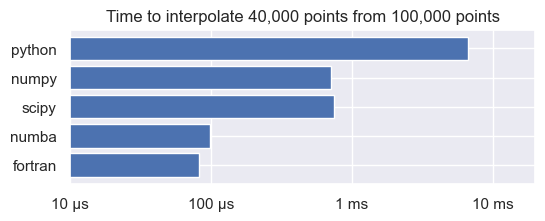

In [12]:
fig, ax = plt.subplots(figsize=(6, 2))
methods = list(reversed(('python', 'numpy', 'scipy', 'numba', 'fortran')))
values = [timings[method].average for method in methods]
ax.barh(methods, values)
ax.set_xscale('log')
ax.set_xlim(1e-5,0.02)
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
ax.set_xticklabels(['10 µs', '100 µs', '1 ms', '10 ms'])
ax.set_title(f"Time to interpolate {N1:,d} points from {N0:,d} points")
plt.show()